# **Facebook Link Prediction**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import random
import math
from scipy.sparse.linalg import svds, eigs
import networkx as nx
import lightgbm as LGB
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import time
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/AppliedAI/Facebook Recommendation/train_woheader.csv'

g = nx.read_edgelist(path, delimiter = ',', create_using = nx.DiGraph(), nodetype = int)

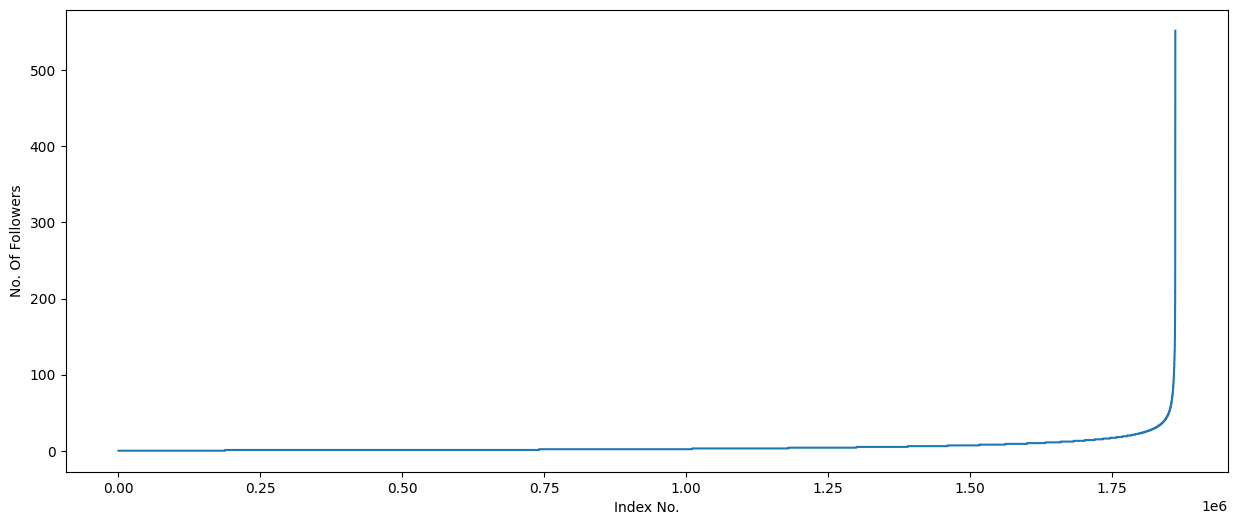

In [4]:
no_of_followers = sorted(list(dict(g.in_degree()).values()))
plt.figure(figsize = (15, 6))
plt.plot(no_of_followers)
plt.xlabel('Index No.')
plt.ylabel('No. Of Followers')
plt.show()

In [5]:
for i in range(90, 101):
    print(i, 'th percentile is:', np.percentile(no_of_followers, i))

90 th percentile is: 12.0
91 th percentile is: 13.0
92 th percentile is: 14.0
93 th percentile is: 15.0
94 th percentile is: 17.0
95 th percentile is: 19.0
96 th percentile is: 21.0
97 th percentile is: 24.0
98 th percentile is: 29.0
99 th percentile is: 40.0
100 th percentile is: 552.0


In [6]:
for i in np.arange(1, 11)/10:
    print(99 + i, 'th percentile is:', np.percentile(no_of_followers, 99 + i))

99.1 th percentile is: 42.0
99.2 th percentile is: 44.0
99.3 th percentile is: 47.0
99.4 th percentile is: 50.0
99.5 th percentile is: 55.0
99.6 th percentile is: 61.0
99.7 th percentile is: 70.0
99.8 th percentile is: 84.0
99.9 th percentile is: 112.0
100.0 th percentile is: 552.0


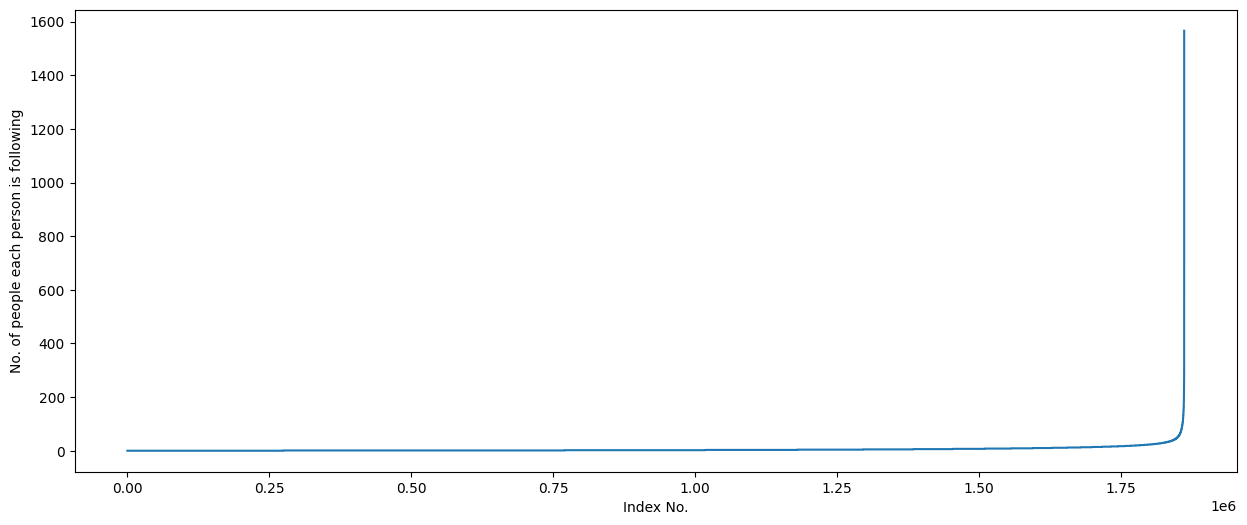

In [7]:
no_of_followees = sorted(list(dict(g.out_degree()).values()))
plt.figure(figsize = (15, 6))
plt.plot(no_of_followees)
plt.xlabel('Index No.')
plt.ylabel('No. of people each person is following')
plt.show()

In [8]:
for i in range(90, 101):
    print(i, 'th percentile is:', np.percentile(no_of_followees, i))

90 th percentile is: 12.0
91 th percentile is: 13.0
92 th percentile is: 14.0
93 th percentile is: 15.0
94 th percentile is: 17.0
95 th percentile is: 19.0
96 th percentile is: 21.0
97 th percentile is: 24.0
98 th percentile is: 29.0
99 th percentile is: 40.0
100 th percentile is: 1566.0


In [9]:
for i in np.arange(1, 11)/10:
    print(99 + i, 'th percentile is:', np.percentile(no_of_followees, 99 + i))

99.1 th percentile is: 42.0
99.2 th percentile is: 45.0
99.3 th percentile is: 48.0
99.4 th percentile is: 52.0
99.5 th percentile is: 56.0
99.6 th percentile is: 63.0
99.7 th percentile is: 73.0
99.8 th percentile is: 90.0
99.9 th percentile is: 123.0
100.0 th percentile is: 1566.0


In [10]:
percentage_of_people_with_zero_followers = round(100 * (sum(np.array(no_of_followers) == 0) / len(no_of_followers)), 3)
print(f"Percentage of people with 0 followers == {percentage_of_people_with_zero_followers} %")

percentage_of_people_with_zero_followees = round(100 * (sum(np.array(no_of_followees) == 0) / len(no_of_followees)), 3)
print(f"Percentage of people with 0 followees == {percentage_of_people_with_zero_followees} %")

Percentage of people with 0 followers == 10.098 %
Percentage of people with 0 followees == 14.741 %


In [11]:
df = pd.read_csv(path, header = None)
len_of_dataset = len(df)
total_nodes = len(list(g.nodes))

print(f"Number of rows in the dataset: {len_of_dataset}")
print(f"Unique users in the data: {total_nodes}")

df.head()

Number of rows in the dataset: 9437519
Unique users in the data: 1862220


,0,1
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [12]:
sample_size = 100000
sampled_df = df.sample(n=sample_size, replace=False, random_state=42)
len_of_sampled_dataset = len(sampled_df)
print(f"Sampled {len_of_sampled_dataset} rows")

Sampled 100000 rows


In [13]:
sampled_df.columns = ['Source', 'Target']
sampled_df['Label'] = 1
sampled_df.head()

,Source,Target,Label
3146484,619970,573968,1
4359561,859478,225717,1
8720380,1721433,1796124,1
2214542,435359,1473069,1
2427171,477487,1119706,1


In [14]:
# Start timer
start_time = time.time()

# Read edges
with open(path, 'r') as file:
    r = csv.reader(file)
    edges = {}
    for edge in r:
        edges[(edge[0], edge[1])] = 1

edges_read_time = time.time()
print(f"Edges read in: {edges_read_time - start_time:.2f} sec")

# Find missing edges
missing_edges = set()
while len(missing_edges) < len_of_sampled_dataset:
    a = random.randint(1, total_nodes)
    b = random.randint(1, total_nodes)
    temp = edges.get((a,b),-1)
    if temp == -1 and a != b:
        try:
            if nx.shortest_path_length(g, source=a, target=b) > 2:
                missing_edges.add((a, b))
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            missing_edges.add((a, b))
    if len(missing_edges) % 20000 == 0:
        print(f"Found {len(missing_edges)} missing edges")

# Print total time
total_time = time.time() - start_time
print(f"Missing edges found in: {time.time() - edges_read_time:.2f} sec")
print(f"Total time: {total_time:.2f} sec")

Edges read in: 16.00 sec
Found 20000 missing edges
Found 40000 missing edges
Found 60000 missing edges
Found 80000 missing edges
Found 100000 missing edges
Missing edges found in: 194.81 sec
Total time: 210.81 sec


In [15]:
df_neg = pd.DataFrame(missing_edges, columns = ['Source', 'Target'])
df_neg['Label'] = 0

In [17]:
df_neg.head()

,Source,Target,Label
0,1046927,714052,0
1,1651210,784171,0
2,1486015,326433,0
3,723987,1626738,0
4,69625,1830103,0


In [16]:
df = pd.concat([sampled_df, df_neg], axis = 0)

In [18]:
df.sample(10)

,Source,Target,Label
94532,228359,1529972,0
78497,1720619,298036,0
39816,252659,170126,0
5724,246399,1060487,0
142485,27565,409829,1
8922218,1761417,272191,1
99647,1122342,1085180,0
78471,1041603,620574,0
8359110,1650445,1451080,1
7771475,1533900,446859,1


In [19]:
print(f"Shape of the dataset: {df.shape}")
print(f"Number of positive edges: {len(sampled_df)}")
print(f"Number of negative edges: {len(df_neg)}")

Shape of the dataset: (200000, 3)
Number of positive edges: 100000
Number of negative edges: 100000


In [20]:
df.to_csv('df_sampled.csv', header = False, index = False)

In [21]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### Feature Engineering

Jaccard Distance : The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members or two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations.

In [22]:
# For followees
def jaccard_for_followees(a, b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(len(set(g.successors(a)).union(set(g.successors(b)))))
    except:
        return 0
    return sim

# For followers
def jaccard_for_followers(a, b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
        return sim
    except:
        return 0

df_train['Jaccard_followees'] = df_train.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)
df_train['Jaccard_followers'] = df_train.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)

df_test['Jaccard_followees'] = df_test.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)
df_test['Jaccard_followers'] = df_test.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)

Cosine Similarity

In [23]:
# For followees
def cosine_for_followees(a, b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
        return sim
    except:
        return 0

# For followers
def cosine_for_followers(a, b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(math.sqrt(len(set(g.predecessors(a)))*len((set(g.predecessors(b))))))
        return sim
    except:
        return 0

df_train['Cosine_followees'] = df_train.apply(lambda row : cosine_for_followees(row['Source'], row['Target']), axis = 1)
df_train['Cosine_followers'] = df_train.apply(lambda row : cosine_for_followers(row['Source'], row['Target']), axis = 1)

df_test['Cosine_followees'] = df_test.apply(lambda row : cosine_for_followees(row['Source'], row['Target']), axis = 1)
df_test['Cosine_followers'] = df_test.apply(lambda row : cosine_for_followers(row['Source'], row['Target']), axis = 1)

Shortest path between 2 nodes

In [24]:
def compute_shortest_path_length(a, b):
    try:
        if g.has_edge(a, b):
            g.remove_edge(a, b)
            p = nx.shortest_path_length(g, source = a, target = b)
            g.add_edge(a, b)
        else:
            p = nx.shortest_path_length(g, source = a, target = b)
        return p
    except:
        return -1

df_train['Shortest_distance'] = df_train.apply(lambda row : compute_shortest_path_length(row['Source'], row['Target']), axis = 1)
df_test['Shortest_distance'] = df_test.apply(lambda row : compute_shortest_path_length(row['Source'], row['Target']), axis = 1)

Adamic / Adar Index

In [25]:
def calculate_adar_index(a, b):
    s = 0
    try:
        n = list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n) != 0:
            for i in n:
                s = s + (1/np.log10(len(list(g.predecessors(i)))))
            return s
        else:
            return 0
    except:
        return 0

df_train['Adar_index'] = df_train.apply(lambda row : calculate_adar_index(row['Source'], row['Target']), axis = 1)
df_test['Adar_index'] = df_test.apply(lambda row : calculate_adar_index(row['Source'], row['Target']), axis = 1)

Feature representing whether the target node is following back or not

In [26]:
def follows_back(a, b):
    if g.has_edge(b, a):
        return 1
    else:
        return 0

df_train['Follows back'] = df_train.apply(lambda row : follows_back(row['Source'], row['Target']), axis = 1)
df_test['Follows back'] = df_test.apply(lambda row : follows_back(row['Source'], row['Target']), axis = 1)

Adding features which depend on the number of followers and followees

In [27]:
num_followers_s = []
num_followees_s = []
num_followers_d = []
num_followees_d = []
inter_followers = []
inter_followees = []

for i, row in df_train.iterrows():
    try:
        s1 = set(g.predecessors(row['Source']))
        s2 = set(g.successors(row['Source']))
    except:
        s1 = set()
        s2 = set()
    try:
        d1 = set(g.predecessors(row['Target']))
        d2 = set(g.successors(row['Target']))
    except:
        d1 = set()
        d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

df_train['num_followers_s'] = num_followers_s
df_train['num_followees_s'] = num_followees_s
df_train['num_followers_d'] = num_followers_d
df_train['num_followees_d'] = num_followees_d
df_train['inter_followers'] = inter_followers
df_train['inter_followees'] = inter_followees

In [28]:
num_followers_s = []
num_followees_s = []
num_followers_d = []
num_followees_d = []
inter_followers = []
inter_followees = []

for i, row in df_test.iterrows():
    try:
        s1 = set(g.predecessors(row['Source']))
        s2 = set(g.successors(row['Source']))
    except:
        s1 = set()
        s2 = set()
    try:
        d1 = set(g.predecessors(row['Target']))
        d2 = set(g.successors(row['Target']))
    except:
        d1 = set()
        d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

df_test['num_followers_s'] = num_followers_s
df_test['num_followees_s'] = num_followees_s
df_test['num_followers_d'] = num_followers_d
df_test['num_followees_d'] = num_followees_d
df_test['inter_followers'] = inter_followers
df_test['inter_followees'] = inter_followees

Weight Features: In order to determine the similarity of nodes an edge weight value can be calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other.
Credit: Graph - based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang.

𝑊 = 1/(sqrt(1 + |X|))

In case we don't get any values for any node, we will use the median value for imputation.

In [29]:
graph = g.nodes
Weight_in = {}
Weight_out = {}
for i in  graph:
    s1 = set(g.predecessors(i))
    Weight_in[i] = 1.0/(np.sqrt(1 + len(s1)))
    s2 = set(g.successors(i))
    Weight_out[i] = 1.0/(np.sqrt(1 + len(s2)))

mean_weight_in = np.median(list(Weight_in.values()))
mean_weight_out = np.median(list(Weight_out.values()))

df_train['weight_in'] = df_train['Target'].apply(lambda x : Weight_in.get(x, mean_weight_in))
df_train['weight_out'] = df_train['Source'].apply(lambda x : Weight_out.get(x, mean_weight_out))

df_test['weight_in'] = df_test['Target'].apply(lambda x : Weight_in.get(x, mean_weight_in))
df_test['weight_out'] = df_test['Source'].apply(lambda x : Weight_out.get(x, mean_weight_out))

# Adding additional ratio feature
df_train['weight_ratio'] = df_train['weight_in']/df_train['weight_out']
df_test['weight_ratio'] = df_test['weight_in']/df_test['weight_out']

SVD features for both Source and Target

In [30]:
sadj_col = sorted(g.nodes())
sadj_dict = {val : idx for idx, val in enumerate(sadj_col)}
Adj = nx.adjacency_matrix(g, nodelist = sadj_col).astype(float)

def svd(x, U):
    try:
        z = sadj_dict[x]
        return U[z]
    except:
        return [0, 0, 0, 0, 0, 0]

U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape', Adj.shape)
print('U Shape', U.shape)
print('V Shape', V.shape)
print('s Shape', s.shape)

df_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = df_train['Source'].apply(lambda x : svd(x, U)).apply(pd.Series)
df_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = df_train['Target'].apply(lambda x: svd(x, U)).apply(pd.Series)
df_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = df_train['Source'].apply(lambda x: svd(x, V.T)).apply(pd.Series)
df_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = df_train['Target'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = df_test['Source'].apply(lambda x : svd(x, U)).apply(pd.Series)
df_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = df_test['Target'].apply(lambda x: svd(x, U)).apply(pd.Series)
df_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = df_test['Source'].apply(lambda x: svd(x, V.T)).apply(pd.Series)
df_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = df_test['Target'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

Adjacency matrix Shape (1862220, 1862220)
U Shape (1862220, 6)
V Shape (6, 1862220)
s Shape (6,)


Dot product of SVD features

In [31]:
train_svd_s = df_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]
train_svd_d = df_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]

test_svd_s = df_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]
test_svd_d = df_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]

df_train['svd_dot'] = np.sum(train_svd_s.values * train_svd_d.values, axis=1)
df_test['svd_dot'] = np.sum(test_svd_s.values * test_svd_d.values, axis=1)

In [32]:
df_train.to_csv('df_train_sample.csv', index = False)
df_test.to_csv('df_test_sample.csv', index = False)

In [33]:
columns_train = df_train.drop(['Source', 'Target', 'Label'], axis = 1).columns
print(f"Name of the columns in the training dataset: {columns_train}")
columns_test = df_test.drop(['Source', 'Target', 'Label'], axis = 1).columns
print(f"Name of the columns in the test dataset: {columns_test}")

Name of the columns in the training dataset: Index(['Jaccard_followees', 'Jaccard_followers', 'Cosine_followees',
       'Cosine_followers', 'Shortest_distance', 'Adar_index', 'Follows back',
       'num_followers_s', 'num_followees_s', 'num_followers_d',
       'num_followees_d', 'inter_followers', 'inter_followees', 'weight_in',
       'weight_out', 'weight_ratio', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'svd_dot'],
      dtype='object')
Name of the columns in the test dataset: Index(['Jaccard_followees', 'Jaccard_followers', 'Cosine_followees',
       'Cosine_followers', 'Shortest_distance', 'Adar_index', 'Follows back',
       'num_followers_s', 'num_followees_s', 'num_followers_d

In [34]:
print(f"Number of columns: {len(columns_train)}")

Number of columns: 41


In [35]:
y_train = df_train['Label']
y_test = df_test['Label']

In [36]:
X_train = df_train.drop(['Source', 'Target', 'Label'], axis = 1)
X_test = df_test.drop(['Source', 'Target', 'Label'], axis = 1)

In [37]:
clf = LGB.LGBMClassifier(n_jobs = -1)
parameters = {
    "n_estimators" : sp_randint(105, 125),
    "max_depth" : sp_randint(10, 15),
    "min_samples_split" : sp_randint(110, 190),
    "min_samples_leaf" : sp_randint(25, 65)
    }

model = RandomizedSearchCV(clf, parameters, cv = 3, scoring = 'f1', return_train_score = True)
model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 53338, number of negative: 53328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9561
[LightGBM] [Info] Number of data points in the train set: 106666, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500047 -> initscore=0.000188


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(n_jobs=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcb83f73a90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcac8e08f50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcb83f73ad0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcb83f73e10>},
                   return_train_score=True, scoring='f1')

In [38]:
model.best_params_

{'max_depth': 10,
 'min_samples_leaf': 34,
 'min_samples_split': 139,
 'n_estimators': 124}

In [39]:
n_estimators = model.best_params_['n_estimators']
max_depth = model.best_params_['max_depth']
min_samples_split = model.best_params_['min_samples_split']
min_samples_leaf = model.best_params_['min_samples_leaf']

In [40]:
clf = LGB.LGBMClassifier(n_estimators = n_estimators,
                         max_depth = max_depth,
                         min_samples_leaf = min_samples_leaf,
                         min_samples_split = min_samples_split,
                         n_jobs = -1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=34. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=34. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 80007, number of negative: 79993
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9596
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500044 -> initscore=0.000175


LGBMClassifier(max_depth=10, min_samples_leaf=34, min_samples_split=139,
               n_estimators=124, n_jobs=-1)

In [41]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=34. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=34. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Unknown parameter: min_samples_split


In [42]:
print('Train confusion_matrix')
print(confusion_matrix(y_train, y_train_pred))
print('Test confusion_matrix')
print(confusion_matrix(y_test, y_test_pred))

Train confusion_matrix
[[79284   709]
 [ 2267 77740]]
Test confusion_matrix
[[19822   185]
 [  606 19387]]


In [43]:
print(f'Train f1 score: {f1_score(y_train, y_train_pred)}')
print(f'Test f1 score: {f1_score(y_test, y_test_pred)}')

Train f1 score: 0.9812187610440753
Test f1 score: 0.9800075824592442


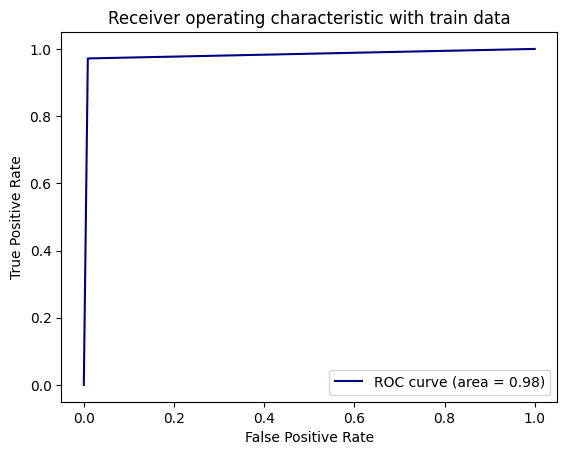

In [44]:
fpr, tpr, ths = roc_curve(y_train, y_train_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', label = 'ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with train data')
plt.legend()
plt.show()

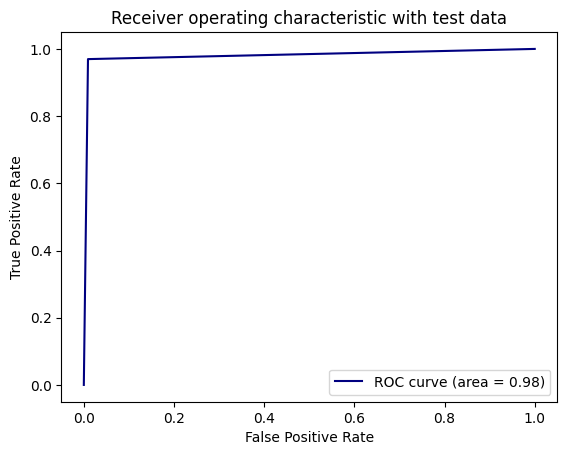

In [45]:
fpr, tpr, ths = roc_curve(y_test, y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', label = 'ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

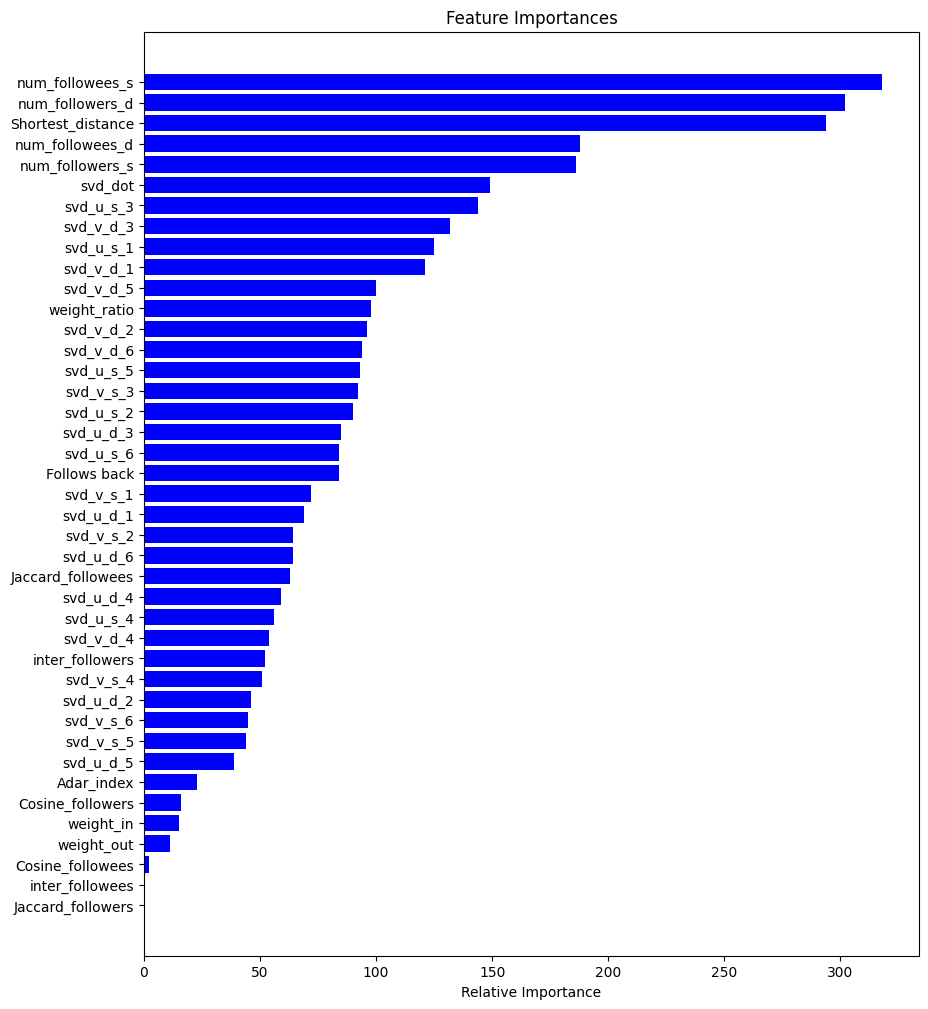

In [46]:
importances = clf.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize = (10, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'blue', align = 'center')
plt.yticks(range(len(indices)), [columns_train[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()